<a href="https://colab.research.google.com/github/Mazgaliev/VBS/blob/master/Analysis_of_open_data_in_macedonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
from datetime import date
from bs4 import BeautifulSoup
import warnings
import requests
from tqdm import tqdm_notebook as tqdm
import json
from datetime import datetime
import matplotlib.pyplot as plt


requests.packages.urllib3.disable_warnings()
warnings.filterwarnings("ignore")

#<font size=6 color = 'Orange'>*Scraping data gov mk for basic information about the datasets*. </font>

In [ ]:
#Function that gets the amount of pages the paginator has.
def getPages(soup):

      ul=soup.find("ul",{"class":"pagination"})
      # lists=ul.find("li")
      lists=ul.findAll("li")
      pages= int(lists[4].text)
      # print(lists)
      
      return pages 

In [ ]:
def getDocuments(souped_html):
  matrix=[]
  list_sets=souped_html.findAll("ul",{"class":"dataset-list list-unstyled"})
  contents=list_sets[0].findAll("div",{"class":"dataset-content"})
  for i,c in enumerate(contents,len(contents)):
    name = c.find("a",href=True).text
    link=c.find("a",href=True)['href']
    matrix.append([name,link])
  return matrix

##<font size=4 color='Green' >*Going through all the datasets and extracting meta data*</font>

In [ ]:
#In this section we will go through all the datasets in data.gov.mk and extract meta data like (supported formats, licences, authors, organizations..)
url= "https://data.gov.mk/mk/dataset/"

#First get all the pages 
resp=requests.get(url)
raw_html=resp.text

souped_html=BeautifulSoup(raw_html)

pages = getPages(souped_html)



In [ ]:
url= "https://data.gov.mk/mk/dataset/?page="

###<font color='White'>Code that finds all the datasets in data.gov.mk with their links and saves them as a csv file.</font>

In [ ]:
allDocs= pd.DataFrame(columns=["name","link"])
for i in tqdm(range(pages),desc="tqdm"):
  # print(url+str(i+1))
  resp_code=500
  while(resp_code!=200):
    resp=requests.get(url+str(i+1))
    resp_code=resp.status_code
    if resp_code==200:
      # print("in")
      raw_html=resp.text
      souped_html=BeautifulSoup(raw_html)
      docs = getDocuments(souped_html)
      tmp = pd.DataFrame(docs,columns=["name","link"])
      allDocs=allDocs.append(tmp)
allDocs.to_csv("DataSet links")

tqdm:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
allDocs=pd.read_csv("DataSet links")

###<font color='White'>Extracting meta data from each document.</font>

In [ ]:
url="https://data.gov.mk"

In [ ]:
links=allDocs['link']

In [ ]:
def scrapeSite(link):

  br_pregledi=None
  br_prezemanja=None
  resp_staus=500
  resp=None
  data_rating=None

  organization="NoOrg"

  while resp_staus!=200:
    resp=requests.get(url+str(link))
    resp_staus=resp.status_code

  souped_html=BeautifulSoup(resp.text)
  set_links=[] 

  module=souped_html.find("section",{"class":"module-content"})
  if module!=None:
    organization=module.find("h1").text

  data_rating=souped_html.find("span",{"class":"star-rating"})
  if data_rating!=None:
    data_rating=len(data_rating.findAll(attrs={"class":"fa fa-star"}))
  
  statDiv=souped_html.find("div",{"class":"dataset-stats"})
  if statDiv!=None:
    stat_elems=statDiv.find_all("div",{"class":"item"})
    
    br_pregledi=int(stat_elems[0].find("span",{"class":"value"}).text)
    br_prezemanja=int(stat_elems[1].find("span",{"class":"value"}).text)

  related_sets_div=souped_html.find("section",{"class":"related-datasets"})
  if related_sets_div!=None:
   rel_datasets=related_sets_div.find_all("h2",{"class":"dataset-heading"})
   for s in rel_datasets:
     link=s.find("a",href=True)['href']
     set_links.append(link)
  
  table_rows=souped_html.find_all("tr")
  row_data={}

  for row in table_rows:
    row_label=row.find("th").text
    row_text=row.find("td")
    if row_text!=None:
      row_text=row_text.text
    row_data[row_label]=row_text
  if data_rating == None:
    data_rating = 0

  return [organization,link,br_pregledi,br_prezemanja,str(set_links),str(row_data),str(data_rating)]

#<font size=6 color = 'Orange'>*Going through all the datasets and extracting data* </font>

In [27]:
from multiprocessing import Process,Queue
import multiprocessing

In [ ]:
#Serial scraping
# mat_data=[]
# length=len(links)
# act_links=links.iloc()

# for i in tqdm(range(length)):
#   data=scrapeSite(url+str(act_links[i]))

#   mat_data.append(data)

In [ ]:
act_links=links.iloc()

In [ ]:
#Parallelized scraping

pool = multiprocessing.Pool(8)
data=pd.DataFrame(pool.map(scrapeSite, act_links),columns=["Organization","Link","Num_views","Num_downloads","Related_sets","MetaData","Otvorenost"])
data.to_csv("Otvoreni podatoci vo mkd")

In [ ]:
import pandas as pd
import matplotlib as plt

data=pd.read_csv("Otvoreni podatoci vo mkd")

<font size = 3 color='Green'>The code above goes through all the sets in the data.gov.mk and returns the extracted data in a dataframe and saves it under the name "Otvoreni podatoci vo mkd" as a CSV file</font>

#<font size=6 color='Orange'>*Api data gathering and parsing*</font>

##*Going through all the organizations and gathering the raw data and saving it*

In [28]:
#This function retrieves a dictionary of all the organizations based on their mapped names.
#This function is necessary because the data retrieved for the sets contains referenecs to the organizations and not the full object organization or title.
def getOrgNames(org):

  name=org['name']
  stat_code=500
  url= "https://data.gov.mk/api/3/action/organization_show"
  data={'id':name}
  while stat_code!=200:
    resp = requests.post(url,json=data)
    stat_code=resp.status_code
  org_data=json.loads(resp.text)['result']
  
  title=org_data['title']

  return title

In [30]:
#Getting all the organizations 

organizations= json.loads(requests.post("https://data.gov.mk/api/3/action/organization_list").text)['result']

In [ ]:
#Gathering the data for dictionary.
orgs={}

for org in organizations:
  orgs[str(org['name'])]=getOrgNames(org)


In [31]:
#Get all the datasets from the API
json_data=json.loads(requests.get("https://data.gov.mk/api/3/action/package_list").text)

#Get the datasets as lists
datasets=json_data['result']

In [ ]:
datasets

In [32]:
#Get Metadata for each set
url="https://data.gov.mk/api/3/action/package_show"
def get_data(link):
  status=500
  parameters= {'id':link}
  while status !=200:
    resp = requests.post(url,json=parameters)
    status=resp.status_code
  data=resp.text
  # print("done with"+link)
  return data


In [33]:
from multiprocessing import Process,Queue
import multiprocessing

#Going through each dataset and getting metadata.
pool = multiprocessing.Pool(12)
all_data=pool.map(get_data, datasets)

In [34]:
#Raw metadata unmodified
metadata=pd.DataFrame(all_data,columns=["TEXTUAL_METADATA"])

In [36]:
metadata.to_csv("TEXTUAL_METADATA_OF_SETS",index=False)

##*Processing the data*

In [35]:
#Gathering the necessary as a dataframe structured data from the api data returned.
# ["set_id","Одржувач","е-маил","Наслов","Дата креирање","Дата модифициран","лиценца","Име на организација","Формат","Големина во KB","Отвореност"]
def getStructuredData(ds):
  final_data=[]

  data=json.loads(ds)['result']

  openness= None
  qa=None
  maintainer=None
  maintainer_email=None
  organization=None
  calculated_openness=None

  set_id=data['id']

  try:
    maintainer=data['maintainer']
    if maintainer =="":
      maintainer="NO_MAINTAINER"
  except:
    maintainer="NO_MAINTAINER"
    pass

  try:
    maintainer_email=data['maintainer_email']
  except:
    maintainer_email="NO_MAINTAINER_EMAIL"
    pass

  title=data['title']
  date_created = datetime.strptime(data['metadata_created'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')

  date_modified=datetime.strptime(data['metadata_modified'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')
 
  try:
    license=data['license_id']  
    if license=="":
      license= "notspecified"
  except:
    license="notspecified"
    

  try:
    organization=data['organization']
    org_name=orgs[organization['name']]
  except:
    org_name="NO ORGANIZATION"

  if license == "notspecified":
      openness="0"

  try:
    qa=data['qa']
    openness=qa['openness_score']
  except:
    qa=None
    openness="0"
  
  resources=data['resources']

  for r in resources:
    resource_format=r['format']
    resource_size=r['size']
    
    doc_updated="NOT_SPECIFIED"
    doc_created="NOT_SPECIFIED"

    try:
      archiv=r['archiver']
      doc_updated=datetime.strptime(archiv['updated'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')
    except:
      doc_updated="NOT_SPECIFIED"
    try:
      doc_created=datetime.strptime(r['created'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')
    except:
      doc_created="NOT_SPECIFIED"

    if resource_format=="":
      resource_format="NOT_SPECIFIED"
    elif resource_format==".csv":
      resource_format="CSV"
    elif resource_format=="XLS" or resource_format=="xlxs" or resource_format==".xlxs" or resource_format==".xlsx":
      resource_format="XLSX" 
    elif resource_format==".pdf":
      resource_format="PDF"
    elif resource_format==".xml":
      resource_format="XML"

    one_star=["DOC","DOCX","PDF"]  
    two_star=["XLSX", "XLS", "MDB", "EXCEL"]
    three_star=[
        "CSV","comma separated values","tsv","tab separated values","wms","web mapping service","geojson","wfs","web feature service","kml","kmz","JSON","XML","shp","rss","gpx"]
    four_star=["sparql","rdf","relational document format","json ld","asc"]

    if resource_format in one_star:
      calculated_openness=1
    elif resource_format in two_star:
      calculated_openness=2
    elif resource_format in three_star:
      calculated_openness=3
    elif resource_format in four_star:
      calculated_openness=4
    else:
      calculated_openness=openness
      calculated_openness=int(calculated_openness)
    if resource_size==None:
      resource_size=0
    final_data.append([set_id,maintainer,maintainer_email,title,date_created,date_modified,license,org_name,resource_format,resource_size/(1024),doc_created,doc_updated,calculated_openness,openness])


  return pd.DataFrame(final_data,columns=["set_id","Одржувач","е-маил","Наслов","Дата креирање","Дата модифициран","лиценца","Име на организација","Формат","Големина во KB","Док Креиран","Док модификуван",'Проценета_отвореност',"Отвореност"])

In [37]:
#Gather the saved data
import pandas as pd
metadata=pd.read_csv("TEXTUAL_METADATA_OF_SETS")

In [41]:
import json

In [42]:
#Saving the (PROCESSED) metadata in a single dataframe
final_frame=pd.DataFrame(columns=["set_id","Одржувач","е-маил","Наслов","Дата креирање","Дата модифициран","лиценца","Име на организација","Формат","Големина во KB","Док Креиран","Док модификуван",'Проценета_отвореност',"Отвореност"])
for ds in metadata.iloc():
  df=getStructuredData(ds[0])
  
  final_frame=pd.concat([final_frame,df])

In [44]:
#Saving the metadata to csv format
final_frame.to_csv("Structured_data_from_set",index=False)

In [45]:
#Read the dataframe
final_frame=pd.read_csv("Structured_data_from_set")

In [49]:
final_frame.head()

,set_id,Одржувач,е-маил,Наслов,Дата креирање,Дата модифициран,лиценца,Име на организација,Формат,Големина во KB,Док Креиран,Док модификуван,Проценета_отвореност,Отвореност
0,6278bee6-663f-44d5-badb-d1e4e1bd269f,Ива Зафировска,iva.manova@karpos.gov.mk,Заслужни граѓани на Општина Карпош,2022-03-09 13:24:25,2022-03-09 13:25:14,notspecified,Општина Карпош,XLSX,28.000000,2022-03-09 13:25:01,2023-04-10 03:10:07,2,0
1,6278bee6-663f-44d5-badb-d1e4e1bd269f,Ива Зафировска,iva.manova@karpos.gov.mk,Заслужни граѓани на Општина Карпош,2022-03-09 13:24:25,2022-03-09 13:25:14,notspecified,Општина Карпош,CSV,2.463867,2022-03-09 13:25:14,2023-04-10 03:10:07,3,0
2,b7643b37-d9d1-433b-a423-d7ba74f01711,Џехан Максудов,cehan_maksud@hotmail.co.uk,Закон и Подзаконски Акти,2022-02-22 07:33:52,2022-02-28 07:21:05,notspecified,Општина Конче,CSV,4.773438,2022-02-22 09:49:54,2023-04-10 03:10:07,3,0
3,49cb3ffb-3538-46bf-a727-57e542ec61a5,Диме Гаштарски,kontakt@moi.gov.mk,Законска инкриминација на кривични дела - сем...,2021-10-29 07:13:04,2021-10-29 07:14:52,notspecified,МВР,CSV,0.691406,2021-10-29 07:14:03,2023-04-10 03:10:08,3,0
4,57cc101d-01e9-461b-a50a-1e0195d1799a,Ива Зафировска,iva.manova@karpos.gov.mk,Закони и подзаконски акти Општина Карпош,2022-05-27 12:38:41,2022-05-27 12:40:49,notspecified,Општина Карпош,XLSX,17.346680,2022-05-27 12:40:30,2023-04-10 03:10:09,2,0


#<font size=6 color='Orange'>*Visualizations*</font>

##<font color='Green'> *The openness of open data in Macedonia visualization*. </font>

<Axes: >

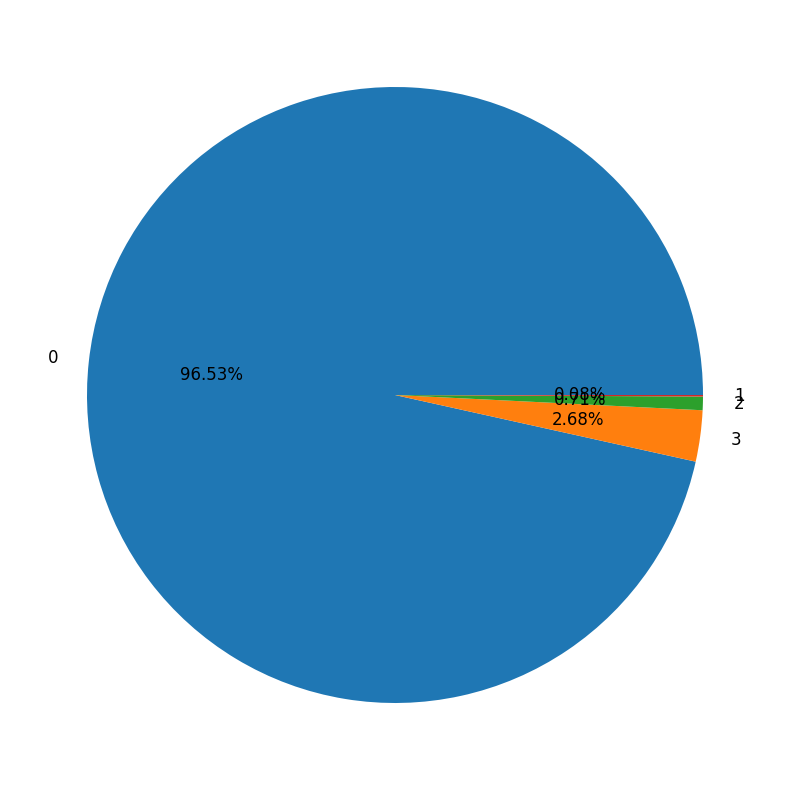

In [74]:
final_frame['Отвореност'].value_counts().plot.pie(
    figsize=(13,10),
                y="Counts",
          autopct='%1.2f%%',
           ylabel='',
           fontsize=12,
           )

<Axes: >

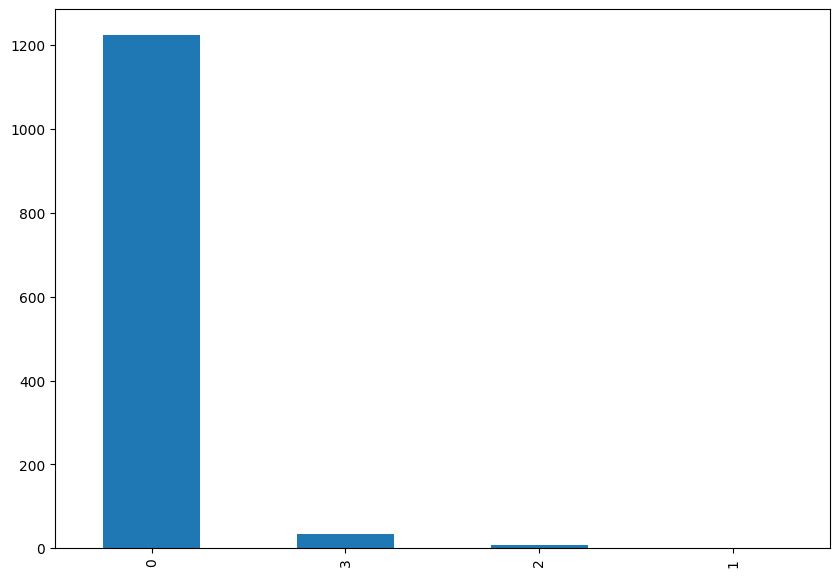

In [75]:
final_frame['Отвореност'].value_counts().plot.bar(figsize=(10,7))

<font color='White'>From the above figures we can see that Macedonia is dominated by open data rated with 0 stars (a whopping **93%** without any open license). And the maximum openness is 3 star, which means that the data is stored in a computer readable format such as CSV, XLSX etc.. aka
"Comma seperated data".</font>

##<font color='Green'>*Visualization of the the organizations activity* </font>


<Axes: >

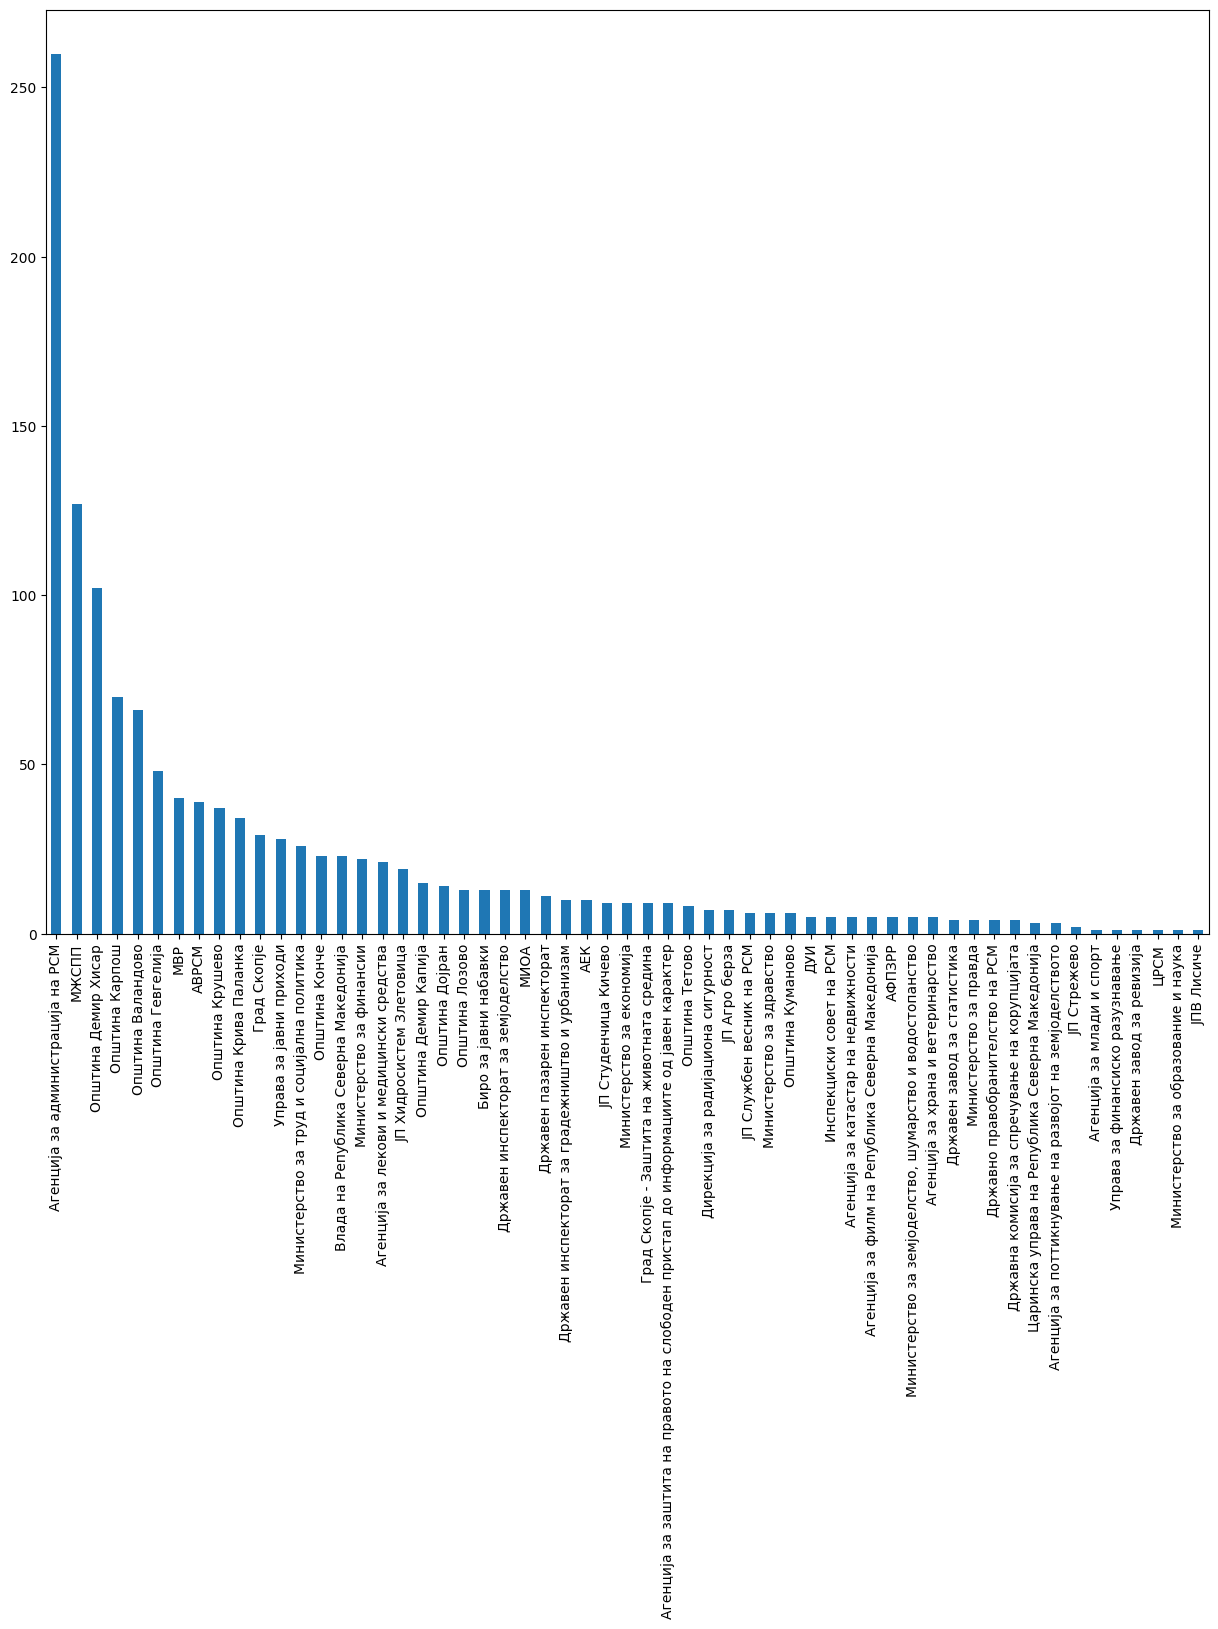

In [77]:
plt.xticks(rotation=90)
final_frame['Име на организација'].value_counts().plot.bar(figsize=(13,10))

<font color='Green'>*Ths visualization shows the amount of datasets that each organization has published ranked from most to least, and we can see that municipality "Демир Хисар" stands first with 51 sets and "ЦРСМ" last with 1 dataset*.</font>

---

<font color='White'>Take note that the organizations that have not published any sets are not present in these visualizations.</font>



##<font color='Green'> Visualization of max openness of open data in each organization.</font>

<Axes: xlabel='Име на организација'>

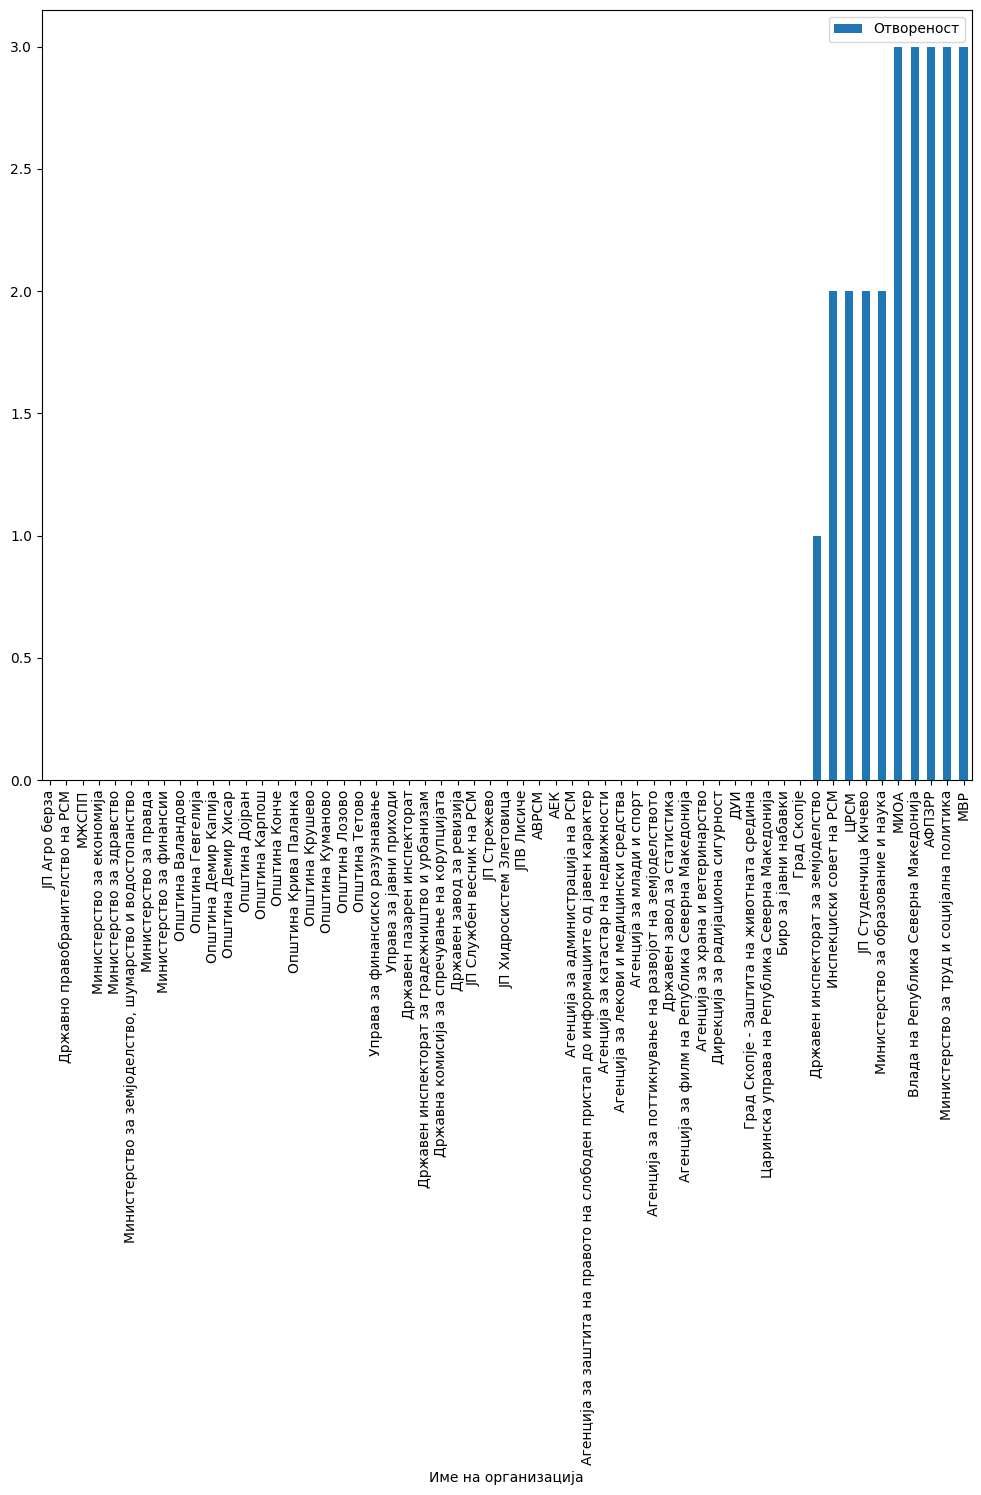

In [114]:
final_frame[['Отвореност','Име на организација']].groupby(["Име на организација"]).max().reset_index().sort_values(by='Отвореност').plot.bar(x="Име на организација",figsize=(12,10))

<font size = 4 color ='White'>This visualization shows each organizations' datasets openness ranking them from low to high, and we can see that organizations such as 'МВР' have 3 star open data which is the maximum in Macedonia and 'МОН' has 2 star data which means that the data has some readable structure.</font>


---


<font color='White' size =4>Still 3 star data is good because anyone with a computer can easily access and process the 3 star data and the 2 star data.

<font color='Red'> A big portion of the organizations in Macedonia do not share their data in a format which could even be graded and even if the document format is according to the guidlines, they have many mistakes in them which means that they are not any useful for work or to be processed by the public or anyone else interested in analyzing the data.</font></font>

##<font color='Green' size=5>Visualization of the number of documents each organization has put out.</font>


<Axes: >

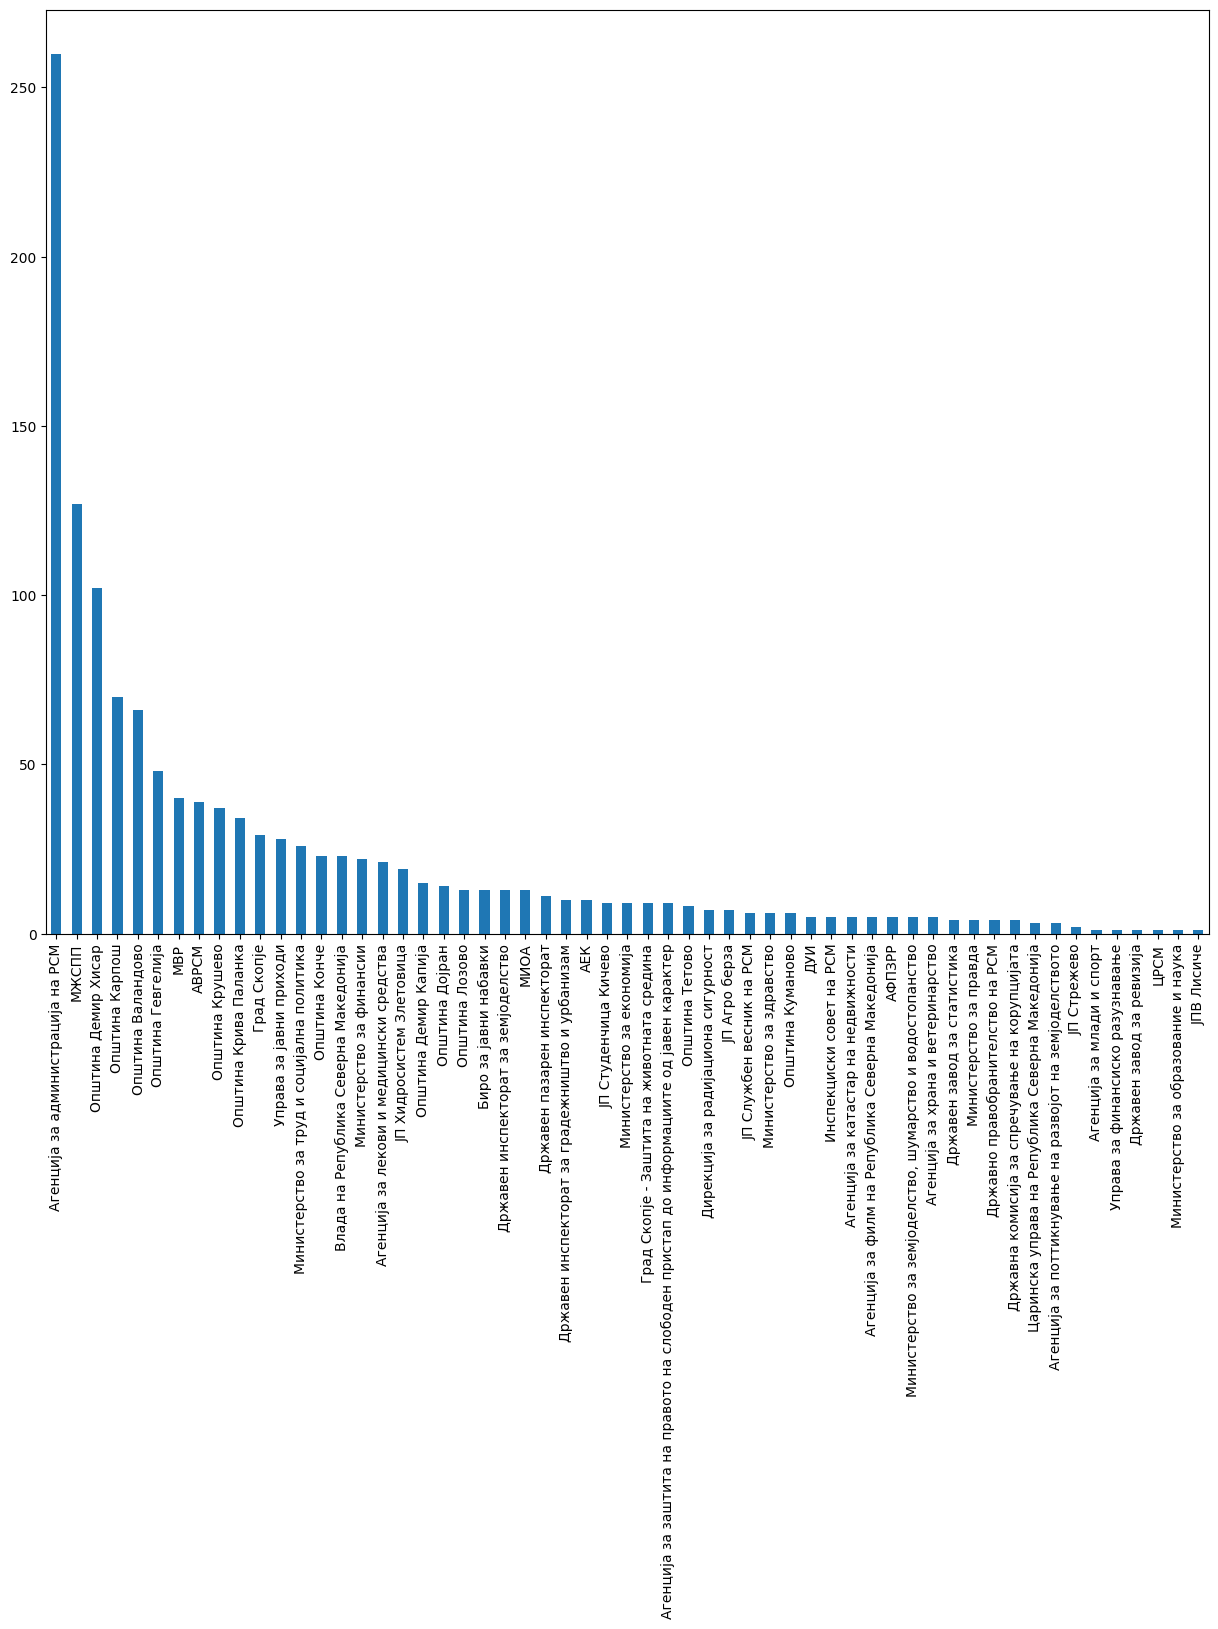

In [82]:
final_frame['Име на организација'].value_counts().plot.bar(figsize=(15,12))


<font color='White' size = 3>This shows theat the agency of administration in Macedonia has the most documents uploaded. As we can see at the stop stands Agency of administration of Macedonia.</font>

<Axes: xlabel='Одржувач'>

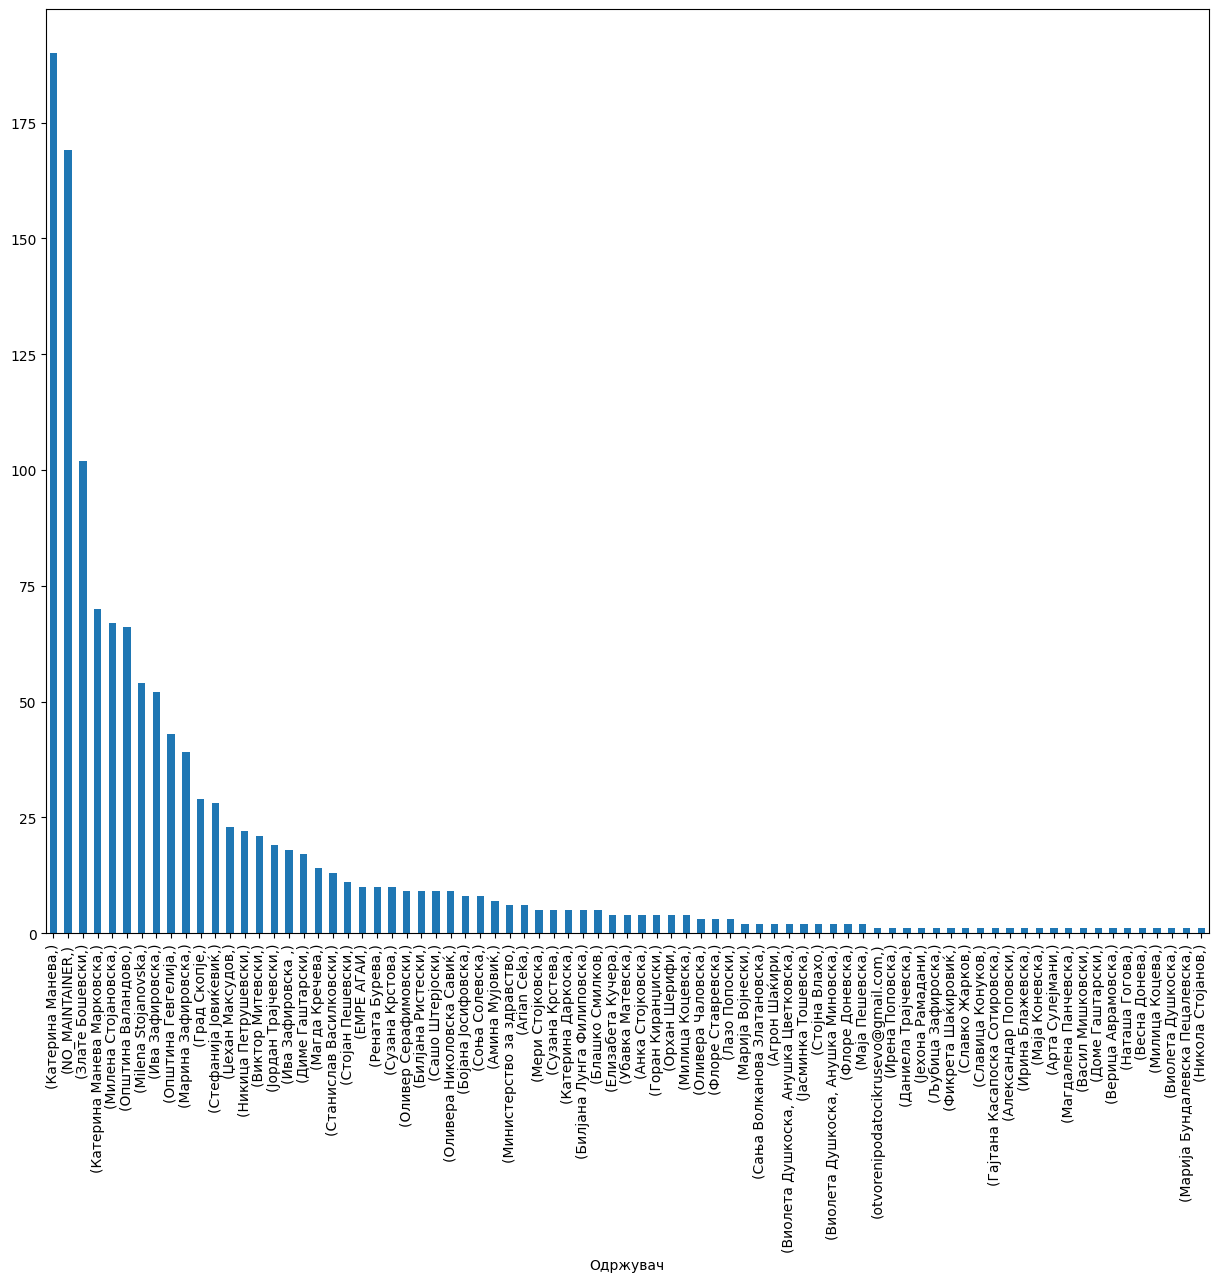

In [83]:
final_frame.value_counts(["Одржувач"]).plot.bar(figsize=(15,12))
#Визуелизација на кои одржувачи се поврзани со најмногу документи за одржување.

<font size=4 color='Green'>This visualization shows the maintainers of datasets and the amount of documents each maintainers maintain.</font>

<font> The dataset maintainers can be contacted in case of some errors in the datasets that need to be fixed, or to contact them for more information regarding the data in the datasets they maintain.</font>

<font color='Red' size=2>In the case where there is no specified maintainer of the dataset the maintainers would be the Organization which has made that specific set.</font>

##<font color='Green' size=5>Visual representation of the amount of data each  that each organization has shared.</font>

<Axes: xlabel='Име на организација'>

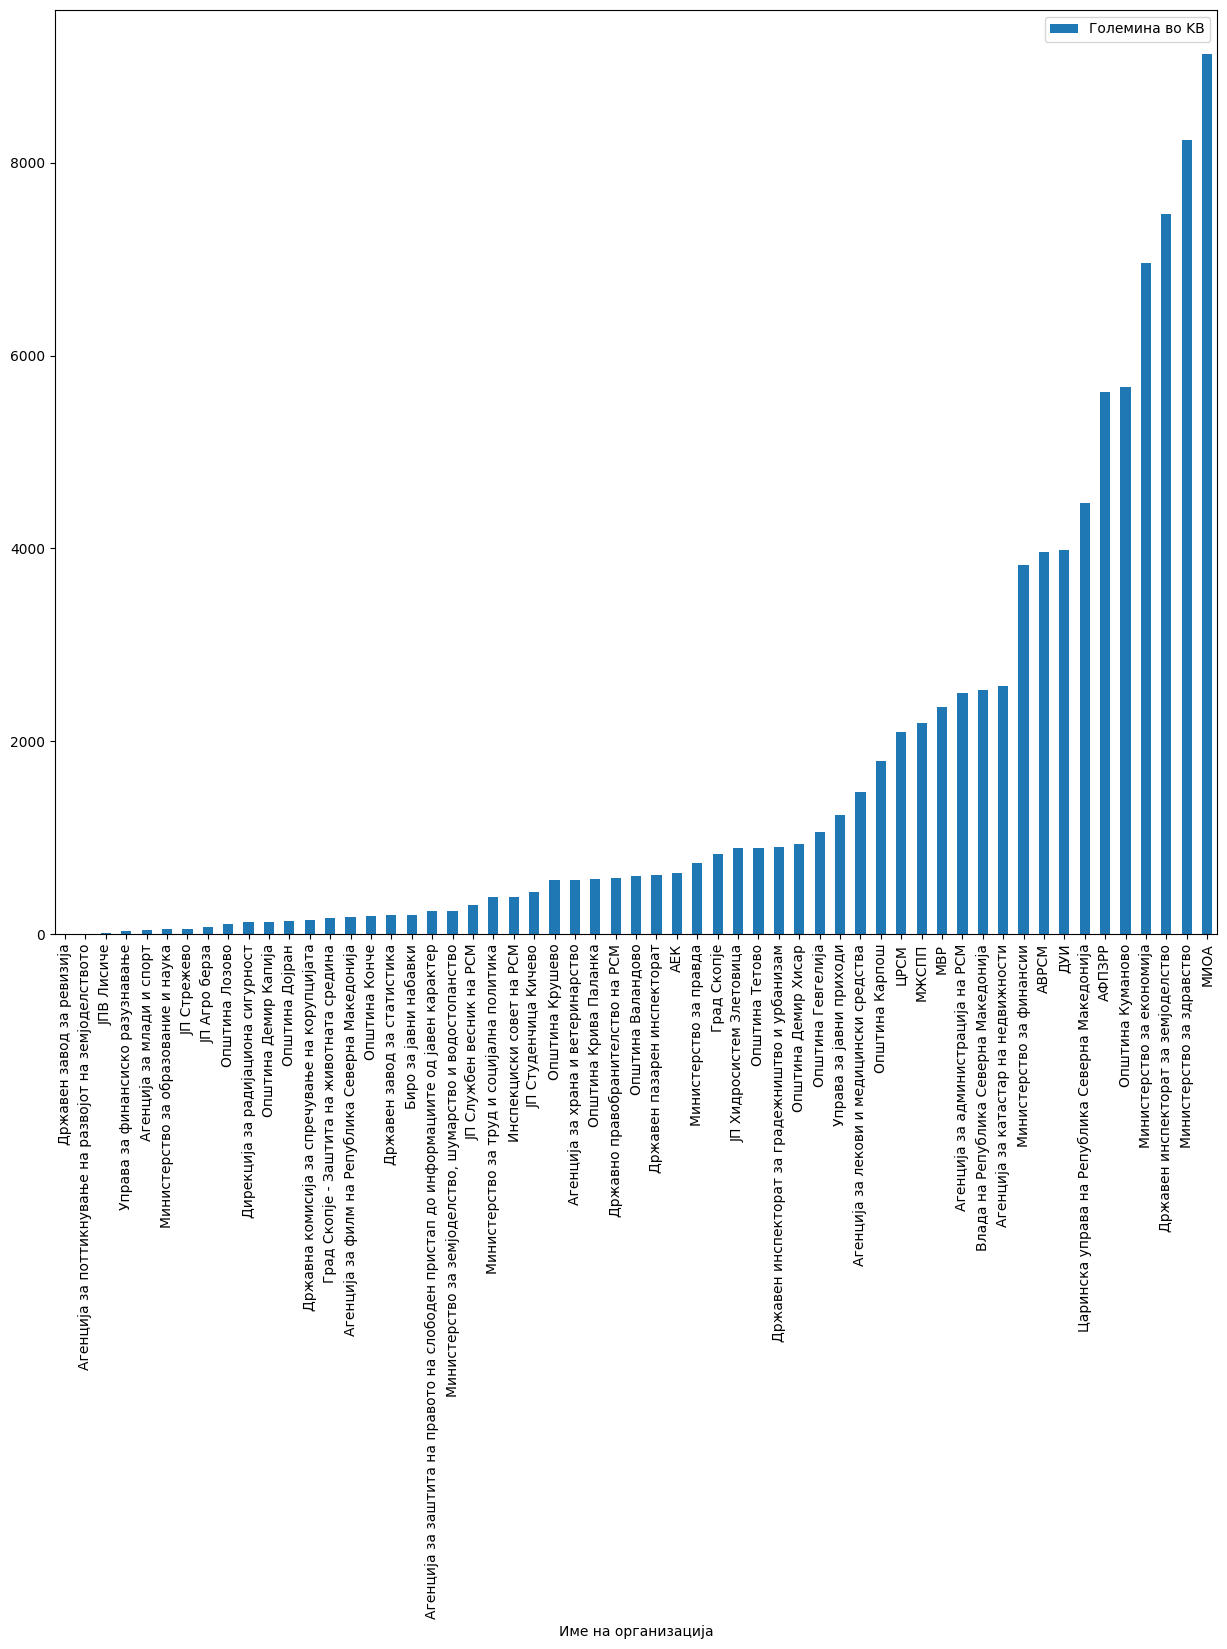

In [84]:
new_df=final_frame[["Име на организација","Големина во KB"]].groupby("Име на организација").sum().reset_index()
new_df.columns=["Име на организација","Големина во KB"]
new_df.sort_values(by="Големина во KB").plot.bar(x="Име на организација",figsize=(15,12))
#Визуелизација на тоа колку севкупно количински во МB има поставено секоја организација од сите документи нејни м-ва.


<font>In this visualization we can see the volume of data each organization has,
ranking at first we have "МИОА" at around 9 Megbytes of data and ranking second  the ministry of health at 8 Megabytes.
</font>

##<font color='Green' size=5>Time series visualization on the amount of Data sets created and edited between the start and present day of storing open data.</font>

In [85]:
dates=final_frame['Дата креирање'].str.split(" ").tolist()
data=[]
for d in dates:
  data.append(d[0])

In [86]:
final_frame['Дата креирање']=pd.DataFrame(data,columns=["Дата креирање"])


In [87]:
new_df=final_frame.value_counts(["set_id",'Дата креирање']).to_frame().reset_index()
new_df.columns=["ID","Дата креирање", "Број"]

In [88]:
new_df.drop(columns=['ID'],inplace=True)

<Axes: xlabel='Дата креирање'>

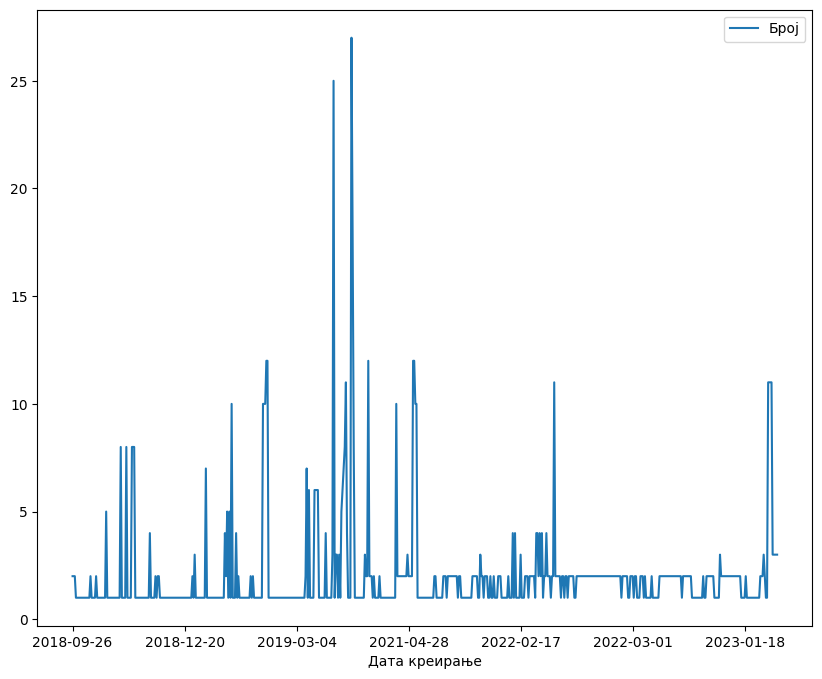

In [89]:
new_df.sort_values(by="Дата креирање").plot(x="Дата креирање",figsize=(10,8))
#Оваа визуелизација покажува колку податочни м-ва има креирано во рангот на датите помеѓу 2018-09-26 и 2023-02-01

<font color='Green'>This time series shows the amount of data that has been submitted as open data in Macedonia, ranging from 2018-09-26 to 2023-02-01</font>

<font size = 4 color='White'>
We can see that the peak of datasets created were in the dates between the third of March 2019 and the end of April 2021.

And also it can be noted that every year we have a rush of datasets that get created in a short period of time apart from the last 2 years, between May 2021 and present date the amount of datasets posted has declined.
</font>

In [90]:
dates=final_frame['Дата модифициран'].str.split(" ").tolist()
data=[]
for d in dates:
  data.append(d[0])

In [91]:
final_frame['Дата модифициран']=pd.DataFrame(data,columns=["Дата модифициран"])

In [92]:
new_df=final_frame.value_counts(["set_id",'Дата модифициран']).to_frame().reset_index()
new_df.columns=["ID","Дата модифициран", "Број"]
new_df.drop(columns=["ID"],inplace=True)

<Axes: xlabel='Дата модифициран'>

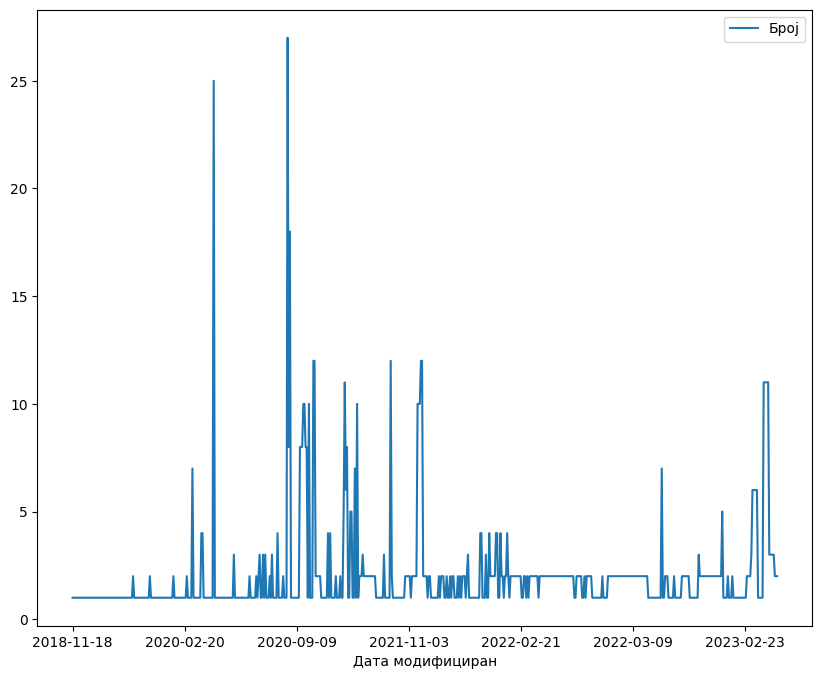

In [93]:
new_df.sort_values(by="Дата модифициран").plot(x="Дата модифициран",figsize=(10,8))
#Оваа визуелизација покажува колку податочни м-ва има креирано во рангот на датите помеѓу 2018-09-26 и 2023-02-01

<font color='White' size=4>This visualization shows the rate at which datasets get updated during the time between the beginning of storing open data and present day.

We can see that between 2019 and 2021 we have the most modifications and updated made to the datasets which is correlated with the data sets created during the same period, which means they get posted then modified due to some problems in the datasets errors missing values and so on.

And after this period the data we can see that there are some small peaks of data sets modified, some yearly monthly and so on.
</font>

<font color='White' size=4></font>

##<font color='Green' size=5>Time series visualization of the amount of documents created and edited between the start and present day of storing open data</font>

In [94]:
dates=final_frame['Док Креиран'].str.split(" ").tolist()
data=[]
for d in dates:
  data.append(d[0])

final_frame['Док Креиран']=pd.DataFrame(data,columns=["Док Креиран"])

new_df=final_frame.value_counts(['Док Креиран']).to_frame().reset_index()
new_df.columns=["Док Креиран", "Број"]

<Axes: xlabel='Док Креиран'>

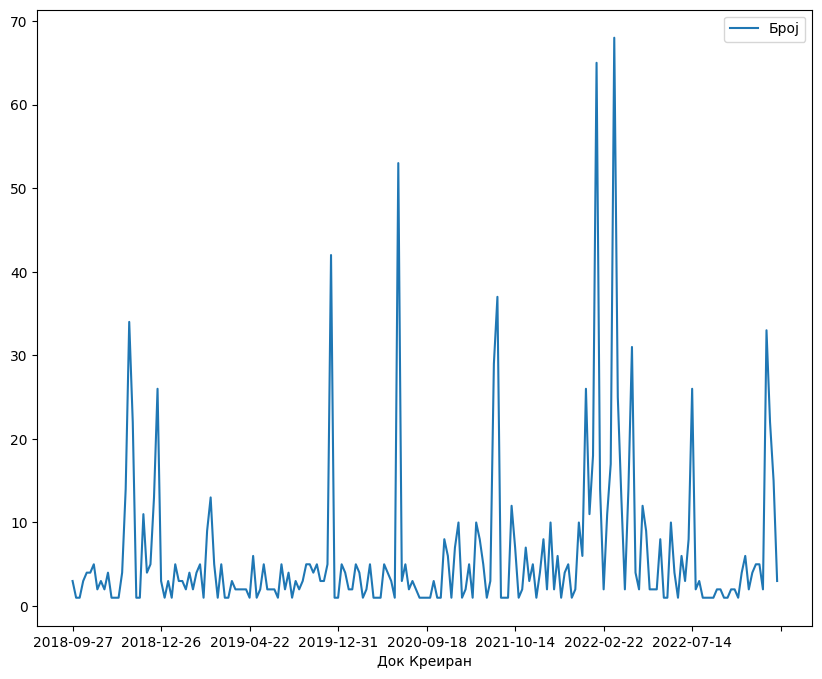

In [95]:
new_df.sort_values(by="Док Креиран").plot(x="Док Креиран",figsize=(10,8))

<font color='Green' size=5>This visualization shows the rate at which documents were created from the beginning of storing open data and present day.</font>

<font color='White' size=4>It can be noted from this visualization, and the visualization for data set creation that some datasets are created empty, and only after a few months or so they are updated with documents.</font>

In [98]:
new_df=final_frame.value_counts(['Док модификуван']).to_frame().reset_index()
new_df.columns=["Док модификуван", "Број"]

<Axes: xlabel='Док модификуван'>

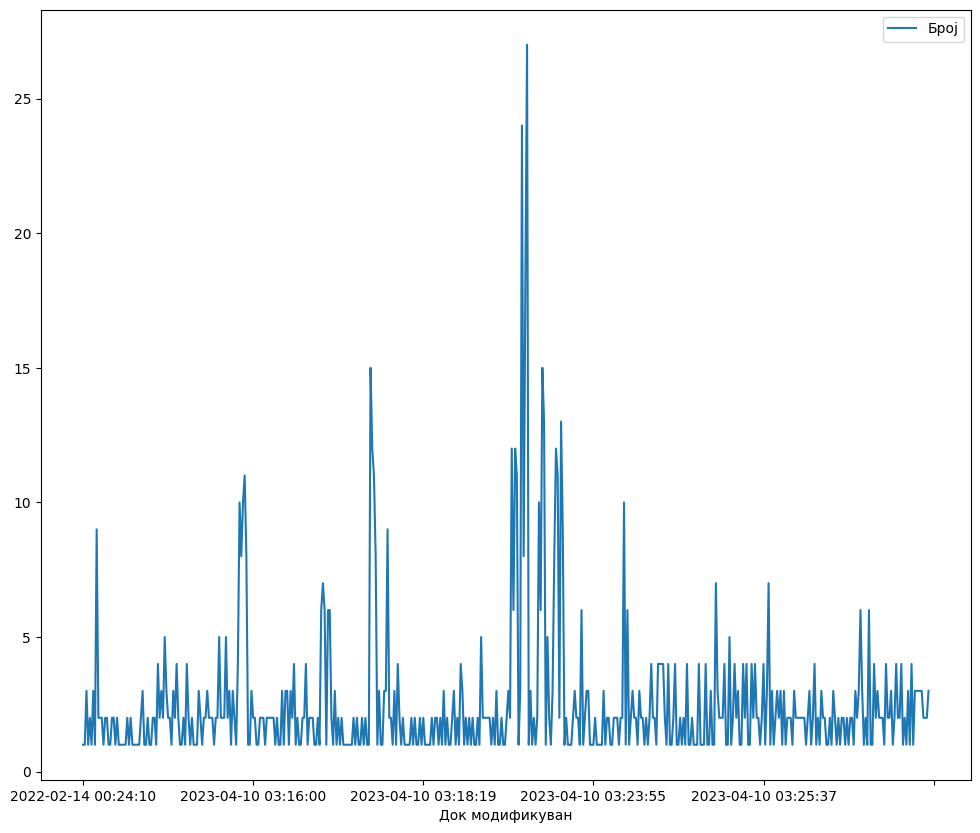

In [99]:
new_df.sort_values(by="Док модификуван").plot(x="Док модификуван",figsize=(12,10))
#Оваа визуелизација покажува колку податочни м-ва има креирано во рангот на датите помеѓу 2018-09-26 и 2023-02-01

<font color='White' size=4>As we can see from this visualization there is a small number of documents that were modified for the last time over a year ago, and the rest of the other documents were updated one month ago in the same day between 3:16:04 AM and 03:28:08 AM. </font>

<font color='Red' size=3>From this visualization we can't get much information out, more analysis needs to be done to see how frequently the documents get modified/updated.

All we can see now is that almost all of them get updated in the same time frame.</font>

##<font color='Green' size=5>Pie visualization of the distribution of the formats of all the documents</font>

<Axes: >

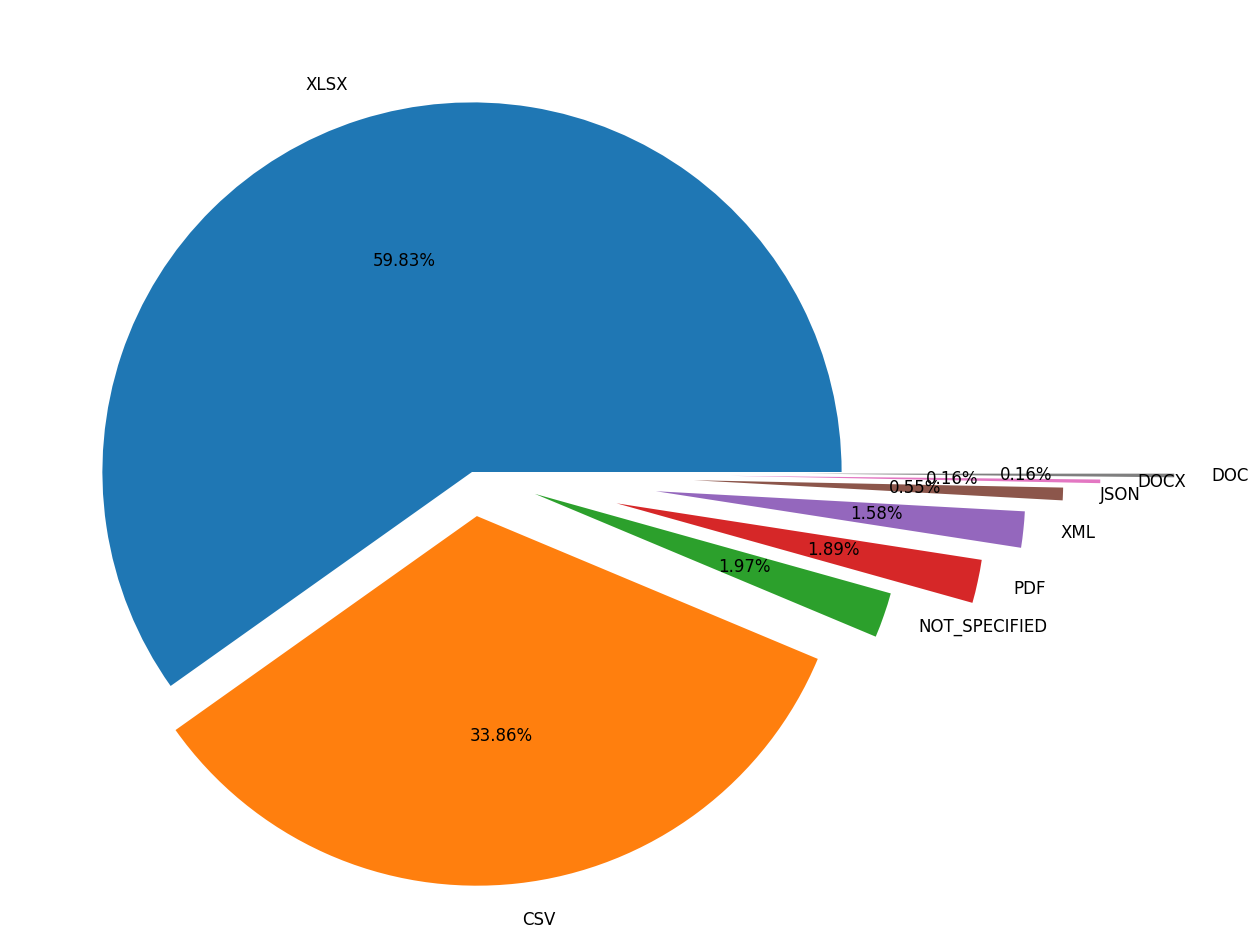

In [100]:
final_frame['Формат'].value_counts().plot.pie(
    figsize=(15,12),
                y="Counts",
          autopct='%1.2f%%',
           ylabel='',
           fontsize=12,
           explode=(0,0.12,0.18,0.4,0.5,0.6,0.7,0.9))

#Оваа визуелизација покажува колку м-ва има процентуално во секој од форматите. 

<font color='Green' size=4> We can see from the above vizualization that in Macedonia the dominating document formats are XLXS **57%** and CSV **36%** which is good, because these formats can easily be processed by computers and be easy to do some statistical analysis on.</font>

<font color='Red' size=3>Note that even though the documents are dominated by these formats there are many mistakes in all of them which still makes up for the 0 star rating (unlicensed) most of them have.</font>

<font color='Red' size=3>Note that there is a section of NOT_SPECIFIED documents, which have some format in which they are stored but are not well documented from the maintainers.</font>

##<font size=5 color='Green'>Visualizations of the calculated data openness in Macedonia</font>


---
The way open the openness score is calculated is by checking the documents formats according to Tim Berners-Lee.

1.   1-Star is DOC,DOCX,PDF
2.   2-Star is EXCEL documents xls xlsx..
3.   3-Star CSV formats, comma seperated data
4.   4-Star sparql,rdf..

And for 5 star it can't be automated yet. Your data needs to Link to other data for more context.




<Axes: >

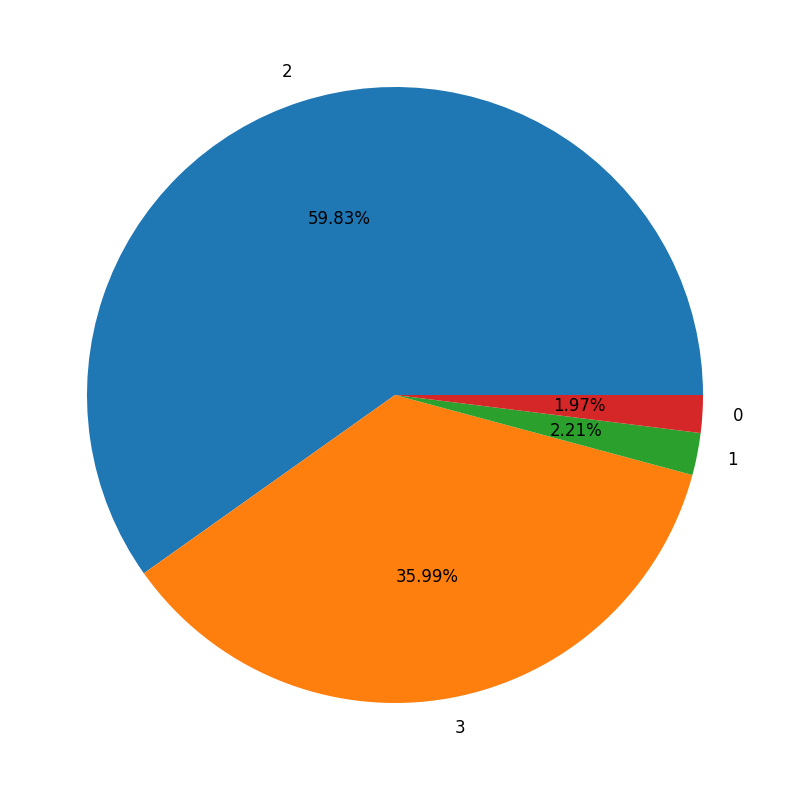

In [101]:
final_frame['Проценета_отвореност'].value_counts().plot.pie(
    figsize=(13,10),
                y="Counts",
          autopct='%1.2f%%',
           ylabel='',
           fontsize=12,)

<font size=4 color='White'>From the pie chart we can see that over 50% of the documents in data gov Macedonia is in a 2-star data form, which means they are in EXCEL format, 38% are in a 3-star data format comma seperated data, CSV and 2% 1-star which is in a format such as PDF, DOC, DOCX and another 2% unrated or empty. Sadly there arent't any 4 and 5 star datasets.</font>


---

Still, these results are not bad. There is a great improvement in how data is stored and it is on set to get much better. And hopefully to achieve 4 and 5 star ratings.

<Axes: xlabel='Име на организација'>

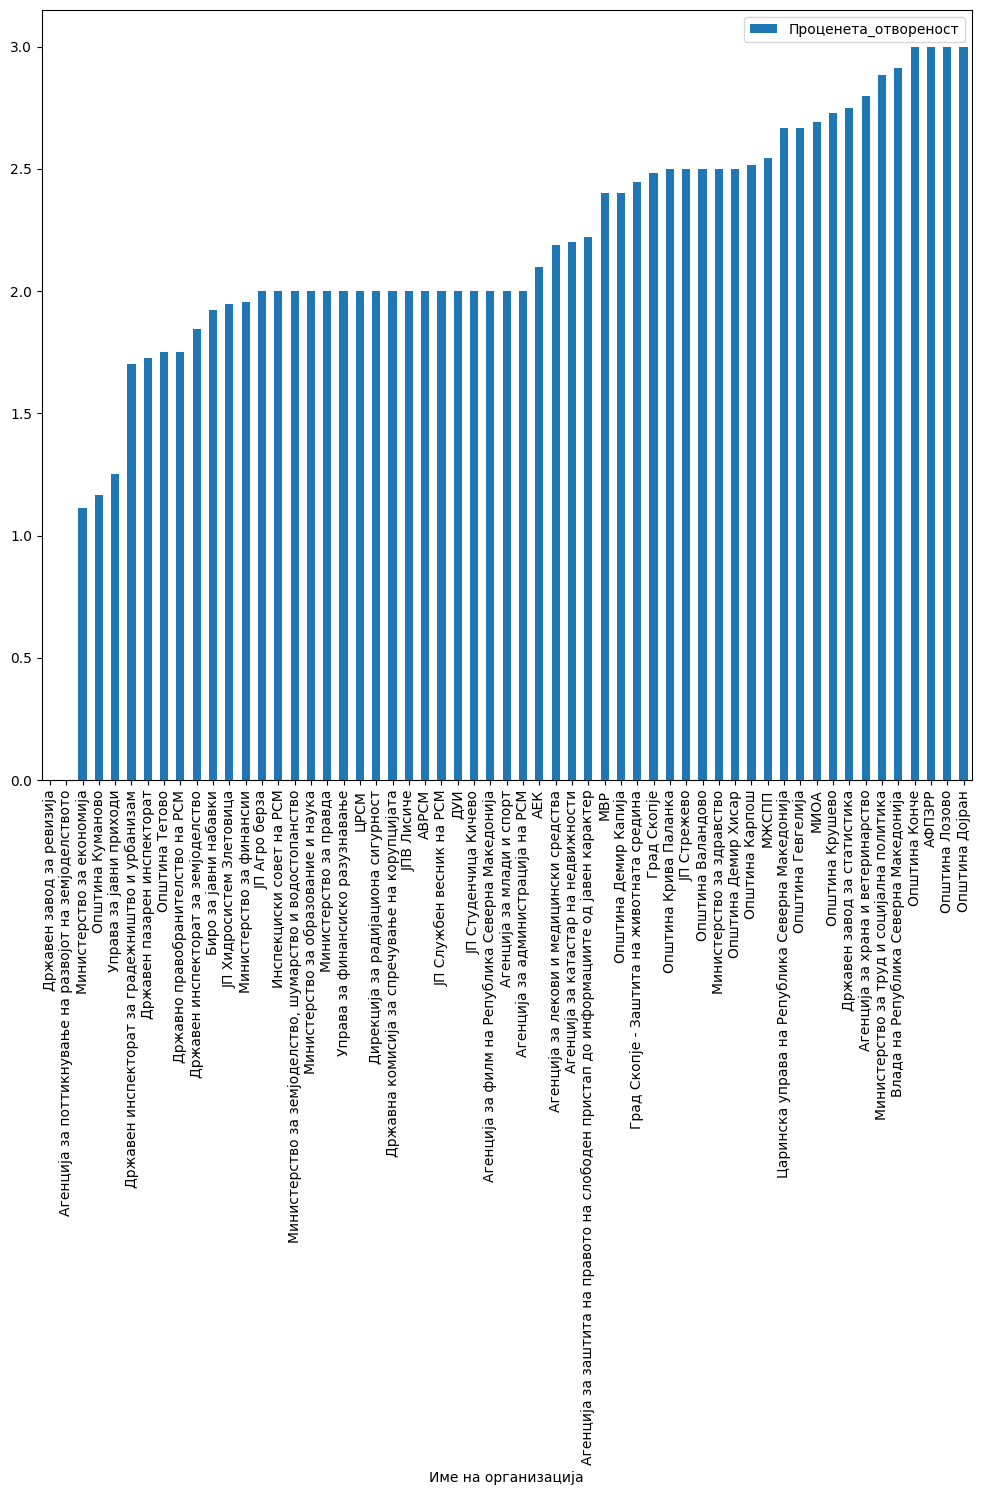

In [102]:
final_frame[['Проценета_отвореност','Име на организација']].groupby(["Име на организација"]).mean().reset_index().sort_values(by='Проценета_отвореност').plot.bar(x="Име на организација",figsize=(12,10))

<font size=4 color='White'>This visualilzation shows the ranking of each of the organizations' datasets average start rating, starting at the lowest LEFT** (Државен завод за ревизија)** and standing at the top 4 with max 3 star average rating АФПЗЗР, Дојран, Лозово and Конче.</font>

<Axes: >

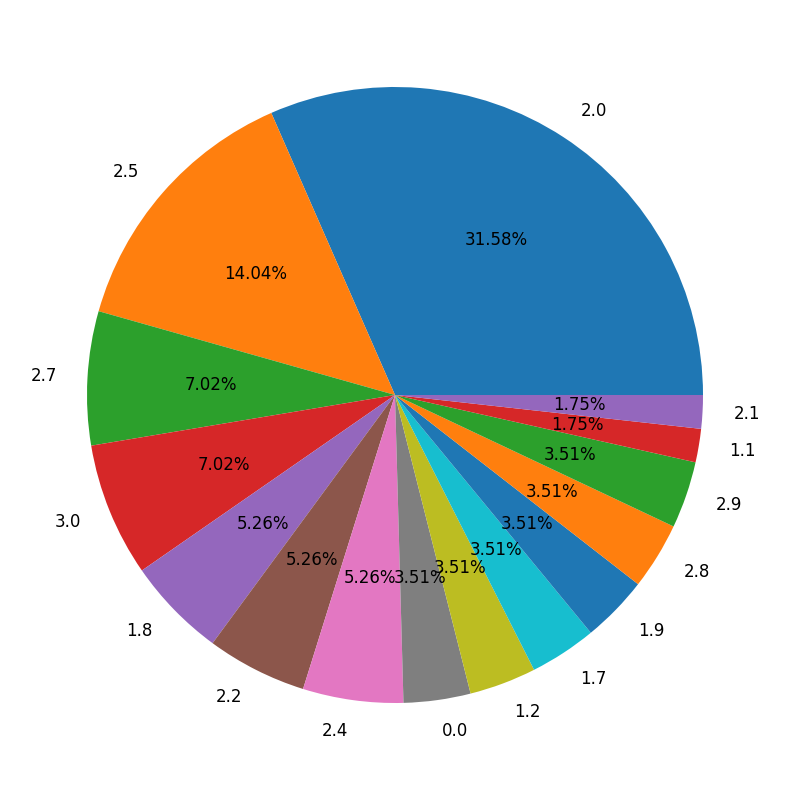

In [103]:
final_frame[['Проценета_отвореност','Име на организација']].groupby(["Име на организација"]).mean().reset_index().round(decimals=1).sort_values(by='Проценета_отвореност').value_counts("Проценета_отвореност").plot.pie(
    figsize=(13,10),
                y="Counts",
          autopct='%1.2f%%',
           ylabel='',
           fontsize=12,
)

<font size=4 color='White'>Here we have a visualization of the percentages for the average Star ratings in our organizations (More detailed distribution of the previous pie that showed just the absolute ratings of the documents).

It can be noted that this visualization shows the average ratings of the datasets rounded to 1 decimal, so some of the datasets numbers may be joined into others by rounding them up by losing soem small precision and gaining better visibility of how the distribution actually looks like.</font>